# Hotel Property Value — Preprocessing & EDA

**Author(s):** Gradient Gang

**Purpose:** EDA, cleaning, feature engineering, and preprocessing pipelines.

In [49]:
# === Basic Imports ===
import os, random, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


# === File Paths ===
TRAIN_PATH = "/kaggle/input/Hotel-Property-Value-Dataset/train.csv"
TEST_PATH  = "/kaggle/input/Hotel-Property-Value-Dataset/test.csv"

# === Load Data ===
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1200, 81)
Test shape: (260, 80)


In [50]:
# === Check for Duplicates ===
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

print("Train shape after drop duplicates:", train.shape)
print("Test shape after drop duplicates:", test.shape)


# === Missing Values ===
null_value_percentages=(train.isna().sum()/train.shape[0])*100
print("\nNull value percentages (training):\n", null_value_percentages)

columns_with_null_values = null_value_percentages[null_value_percentages>0]
print("\nColumns with null values (training):\n",columns_with_null_values)


null_value_percentages_test=(test.isna().sum()/test.shape[0])*100
print("\nNull value percentages (test):\n", null_value_percentages_test)

columns_with_null_values_test = null_value_percentages_test[null_value_percentages_test>0]
print("\nColumns with null values (test):\n",columns_with_null_values_test)

Train shape after drop duplicates: (1200, 81)
Test shape after drop duplicates: (260, 80)

Null value percentages (training):
 Id                   0.000000
PropertyClass        0.000000
ZoningCategory       0.000000
RoadAccessLength    18.583333
LandArea             0.000000
                      ...    
MonthSold            0.000000
YearSold             0.000000
DealType             0.000000
DealCondition        0.000000
HotelValue           0.000000
Length: 81, dtype: float64

Columns with null values (training):
 RoadAccessLength           18.583333
ServiceLaneType            93.750000
FacadeType                 58.500000
FacadeArea                  0.583333
BasementHeight              2.416667
BasementCondition           2.416667
BasementExposure            2.500000
BasementFacilityType1       2.416667
BasementFacilityType2       2.416667
ElectricalSystem            0.083333
LoungeQuality              46.666667
ParkingType                 5.416667
ParkingConstructionYear     5.416

Here we have divided the columns based on the percentages of null values into the following categories:
* Columns with very less null values (0-5%)
* Columns with moderate amount of null values (5-50%)
* Columns with a lot of null values (>50%)

### Null Value Stuff

In [51]:
#=== Dropping Columns with lot of null values ===
columns_to_drop = null_value_percentages[null_value_percentages>50].index
train.drop(columns=columns_to_drop, inplace=True)

columns_to_drop_test = null_value_percentages_test[null_value_percentages_test>50].index
test.drop(columns=columns_to_drop_test, inplace=True)

In [52]:
#=== Checking Columns with moderate amount of null values ===
moderate_null_cols = null_value_percentages[(null_value_percentages >= 5) & (null_value_percentages <= 50)].index
moderate_null_cols_test = null_value_percentages_test[(null_value_percentages_test >= 5) & (null_value_percentages_test <= 50)].index

print("training data:",moderate_null_cols)
print("testing data:",moderate_null_cols_test)

print("\n")

for column in moderate_null_cols:
    if train[column].dtype == 'object':
        print(f"CATEGORICAL: {column}")
        print(train[column].value_counts(dropna=False))
    else:
        missing_count = train[column].isna().sum()
        print(f"NUMERIC: {column}")
        print(train[column].describe())
        print(f"Missing values: {missing_count}")
        
print("-" * 50)
for column in moderate_null_cols_test:
    if test[column].dtype == 'object':
        print(f"CATEGORICAL: {column}")
        print(test[column].value_counts(dropna=False))
    else:
        missing_count = test[column].isna().sum()
        print(f"NUMERIC: {column}")
        print(test[column].describe())
        print(f"Missing values: {missing_count}")

training data: Index(['RoadAccessLength', 'LoungeQuality', 'ParkingType',
       'ParkingConstructionYear', 'ParkingFinish', 'ParkingQuality',
       'ParkingCondition'],
      dtype='object')
testing data: Index(['RoadAccessLength', 'LoungeQuality', 'ParkingType',
       'ParkingConstructionYear', 'ParkingFinish', 'ParkingQuality',
       'ParkingCondition'],
      dtype='object')


NUMERIC: RoadAccessLength
count    977.000000
mean      70.228250
std       24.886507
min       21.000000
25%       59.000000
50%       70.000000
75%       80.000000
max      313.000000
Name: RoadAccessLength, dtype: float64
Missing values: 223
CATEGORICAL: LoungeQuality
LoungeQuality
NaN    560
Gd     317
TA     259
Fa      27
Ex      21
Po      16
Name: count, dtype: int64
CATEGORICAL: ParkingType
ParkingType
Attchd     714
Detchd     315
BuiltIn     76
NaN         65
Basment     16
CarPort      8
2Types       6
Name: count, dtype: int64
NUMERIC: ParkingConstructionYear
count    1135.000000
mean     1978

In [53]:
#=== Imputing Columns with moderate amount of null values ===

# Columns where null represents absence
categorical_absence_map = {
    'LoungeQuality': 'NoLounge',
    'ParkingType': 'NoParking',
    'ParkingFinish': 'NoParking',
    'ParkingQuality': 'NoParking',
    'ParkingCondition': 'NoParking'
}

# Seed for reproducibility
np.random.seed(42)
# Impute moderate nulls
for col in moderate_null_cols:
    # Missing flags
    train[f"{col}_was_missing"] = train[col].isna().astype(int)
    test[f"{col}_was_missing"] = test[col].isna().astype(int)
    
    # Categorical absence
    if col in categorical_absence_map:
        train[col] = train[col].fillna(categorical_absence_map[col])
        if col in test.columns:
            test[col] = test[col].fillna(categorical_absence_map[col])
    # Other categorical -> random sampling
    elif train[col].dtype=='object':
        obs_vals = train[col].dropna().unique()
        train.loc[train[col].isna(), col] = np.random.choice(obs_vals, size=train[col].isna().sum(), replace=True)
        if col in test.columns:
            obs_vals_test = test[col].dropna().unique()
            test.loc[test[col].isna(), col] = np.random.choice(obs_vals_test, size=test[col].isna().sum(), replace=True)
    # Numeric -> random sampling from train
    else:
        obs_vals = train[col].dropna().values
        train.loc[train[col].isna(), col] = np.random.choice(obs_vals, size=train[col].isna().sum(), replace=True)
        if col in test.columns:
            test.loc[test[col].isna(), col] = np.random.choice(obs_vals, size=test[col].isna().sum(), replace=True)

In [54]:
#=== Verification ===

for column in moderate_null_cols:
    if train[column].dtype == 'object':
        print(f"CATEGORICAL: {column}")
        print(train[column].value_counts(dropna=False))
    else:
        missing_count = train[column].isna().sum()
        print(f"NUMERIC: {column}")
        print(train[column].describe())
        print(f"Missing values: {missing_count}")
        
print("-" * 50)
for column in moderate_null_cols_test:
    if test[column].dtype == 'object':
        print(f"CATEGORICAL: {column}")
        print(test[column].value_counts(dropna=False))
    else:
        missing_count = test[column].isna().sum()
        print(f"NUMERIC: {column}")
        print(test[column].describe())
        print(f"Missing values: {missing_count}")



NUMERIC: RoadAccessLength
count    1200.000000
mean       69.913333
std        24.522785
min        21.000000
25%        59.000000
50%        69.500000
75%        80.000000
max       313.000000
Name: RoadAccessLength, dtype: float64
Missing values: 0
CATEGORICAL: LoungeQuality
LoungeQuality
NoLounge    560
Gd          317
TA          259
Fa           27
Ex           21
Po           16
Name: count, dtype: int64
CATEGORICAL: ParkingType
ParkingType
Attchd       714
Detchd       315
BuiltIn       76
NoParking     65
Basment       16
CarPort        8
2Types         6
Name: count, dtype: int64
NUMERIC: ParkingConstructionYear
count    1200.000000
mean     1978.773333
std        24.674602
min      1900.000000
25%      1962.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: ParkingConstructionYear, dtype: float64
Missing values: 0
CATEGORICAL: ParkingFinish
ParkingFinish
Unf          492
RFn          348
Fin          295
NoParking     65
Name: count, dtype: int64
CATE

In [55]:
#=== Checking Columns with less amount of null values ===
less_null_cols = null_value_percentages[(null_value_percentages > 0) & (null_value_percentages < 5)].index
less_null_cols_test = null_value_percentages_test[(null_value_percentages_test > 0) & (null_value_percentages_test < 5)].index

print("Training data columns with low nulls:", less_null_cols)
print("Testing data columns with low nulls:", less_null_cols_test)
print("="*80)

# Function to inspect a column safely
def inspect_column(df, col):
    missing_count = df[col].isna().sum()
    missing_pct = missing_count / len(df) * 100
    
    print(f"Column: {col}")
    print(f"Type: {'Categorical' if df[col].dtype=='object' else 'Numeric'}")
    print(f"Missing: {missing_count} ({missing_pct:.3f}%)")
    
    if df[col].dtype == 'object':
        # Include NaN explicitly
        print("Value counts (including NaN):")
        print(df[col].value_counts(dropna=False))
    else:
        print("Descriptive stats (numeric):")
        print(df[col].describe())
    print("-"*50)

# Inspect training data
print("TRAINING DATA:")
for col in less_null_cols:
    inspect_column(train, col)

# Inspect testing data
print("TESTING DATA:")
for col in less_null_cols_test:
    inspect_column(test, col)


Training data columns with low nulls: Index(['FacadeArea', 'BasementHeight', 'BasementCondition', 'BasementExposure',
       'BasementFacilityType1', 'BasementFacilityType2', 'ElectricalSystem'],
      dtype='object')
Testing data columns with low nulls: Index(['FacadeArea', 'BasementHeight', 'BasementCondition', 'BasementExposure',
       'BasementFacilityType1', 'BasementFacilityType2'],
      dtype='object')
TRAINING DATA:
Column: FacadeArea
Type: Numeric
Missing: 7 (0.583%)
Descriptive stats (numeric):
count    1193.000000
mean      103.448449
std       172.339311
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1378.000000
Name: FacadeArea, dtype: float64
--------------------------------------------------
Column: BasementHeight
Type: Categorical
Missing: 29 (2.417%)
Value counts (including NaN):
BasementHeight
TA     530
Gd     508
Ex     103
Fa      30
NaN     29
Name: count, dtype: int64
------------------------------------------------

In [56]:
# === Low missing values (0-5%) ===
less_null_cols = null_value_percentages[(null_value_percentages>0) & (null_value_percentages<5)].index
less_null_cols_test = null_value_percentages_test[(null_value_percentages_test>0) & (null_value_percentages_test<5)].index

# Basement, numeric, and categorical low-null columns
basement_cols = ['BasementHeight', 'BasementCondition', 'BasementExposure',
                 'BasementFacilityType1', 'BasementFacilityType2']
numeric_cols_low = ['FacadeArea']
categorical_cols_low = ['ElectricalSystem']

def impute_low_nulls(df):
    np.random.seed(42)
    for col in less_null_cols:
        if col in df.columns:
            df[f"{col}_was_missing"] = df[col].isna().astype(int)
    
    # Basement
    for idx, row in df.iterrows():
        if all(col in df.columns for col in basement_cols):
            if row[basement_cols].isna().all():
                df.loc[idx, basement_cols] = "NoBasement"
            else:
                for col in basement_cols:
                    if pd.isna(row[col]):
                        df.loc[idx, col] = np.random.choice(df[col].dropna().values)
    
    # Numeric
    for col in numeric_cols_low:
        if col in df.columns:
            null_mask = df[col].isna()
            df.loc[null_mask, col] = np.random.choice(df[col].dropna().values, size=null_mask.sum(), replace=True)
    
    # Other categorical
    for col in categorical_cols_low:
        if col in df.columns:
            null_mask = df[col].isna()
            df.loc[null_mask, col] = np.random.choice(df[col].dropna().values, size=null_mask.sum(), replace=True)

# Apply low-null imputation
impute_low_nulls(train)
impute_low_nulls(test)

In [57]:
#=== Checking Columns with less amount of null values ===
print("Training data columns with low nulls:", less_null_cols)
print("Testing data columns with low nulls:", less_null_cols_test)
print("="*80)

# Function to inspect a column safely
def inspect_column(df, col):
    missing_count = df[col].isna().sum()
    missing_pct = missing_count / len(df) * 100
    
    print(f"Column: {col}")
    print(f"Type: {'Categorical' if df[col].dtype=='object' else 'Numeric'}")
    print(f"Missing: {missing_count} ({missing_pct:.3f}%)")
    
    if df[col].dtype == 'object':
        # Include NaN explicitly
        print("Value counts (including NaN):")
        print(df[col].value_counts(dropna=False))
    else:
        print("Descriptive stats (numeric):")
        print(df[col].describe())
    print("-"*50)

# Inspect training data
print("TRAINING DATA:")
for col in less_null_cols:
    inspect_column(train, col)

# Inspect testing data
print("TESTING DATA:")
for col in less_null_cols_test:
    inspect_column(test, col)


Training data columns with low nulls: Index(['FacadeArea', 'BasementHeight', 'BasementCondition', 'BasementExposure',
       'BasementFacilityType1', 'BasementFacilityType2', 'ElectricalSystem'],
      dtype='object')
Testing data columns with low nulls: Index(['FacadeArea', 'BasementHeight', 'BasementCondition', 'BasementExposure',
       'BasementFacilityType1', 'BasementFacilityType2'],
      dtype='object')
TRAINING DATA:
Column: FacadeArea
Type: Numeric
Missing: 0 (0.000%)
Descriptive stats (numeric):
count    1200.000000
mean      103.915000
std       173.031421
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1378.000000
Name: FacadeArea, dtype: float64
--------------------------------------------------
Column: BasementHeight
Type: Categorical
Missing: 0 (0.000%)
Value counts (including NaN):
BasementHeight
TA            530
Gd            508
Ex            103
Fa             30
NoBasement     29
Name: count, dtype: int64
--------------

### Outlier detection

In [58]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_test = test.select_dtypes(include=[np.number]).columns.tolist()

class OutlierHandler:
    def __init__(self, col):
        q1 = col.quantile(0.25)
        q3 = col.quantile(0.75)
        iqr = q3 - q1
        self.lower = q1 - 1.5*iqr
        self.upper = q3 + 1.5*iqr
    def cap(self, val):
        return min(max(val, self.lower), self.upper)

for col in numeric_cols:
    handler = OutlierHandler(train[col])
    train[col] = train[col].apply(handler.cap)
    
for col in numeric_cols_test:
    if col in train.columns:
        handler = OutlierHandler(train[col])
        test[col] = test[col].apply(handler.cap)

### Standardisation

In [59]:
common_numeric_cols = [c for c in numeric_cols if c in test.columns]
scaler = StandardScaler()
train[common_numeric_cols] = scaler.fit_transform(train[common_numeric_cols])
test[common_numeric_cols] = scaler.transform(test[common_numeric_cols])

## EDA

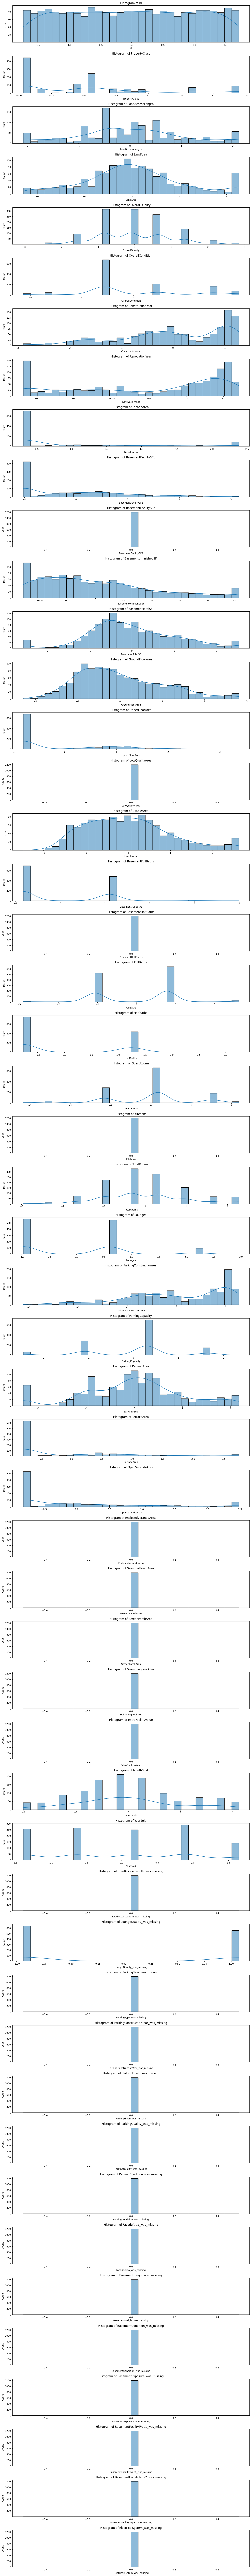

In [61]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(15, len(common_numeric_cols)*3))
for i, col in enumerate(common_numeric_cols):
    plt.subplot(len(common_numeric_cols), 1, i+1)
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

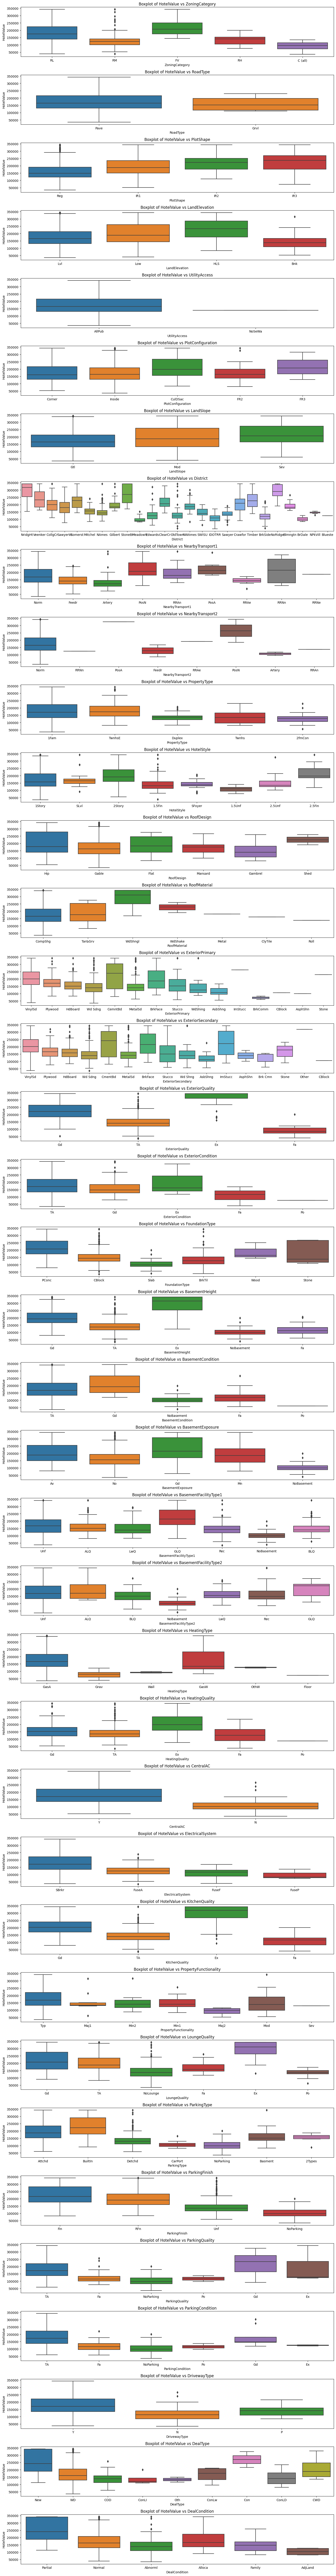

In [62]:
categorical_cols_final = train.select_dtypes(include=['object']).columns.tolist()
plt.figure(figsize=(15, len(categorical_cols_final)*3))
for i, col in enumerate(categorical_cols_final):
    plt.subplot(len(categorical_cols_final), 1, i+1)
    sns.boxplot(x=train[col], y=train['HotelValue'])
    plt.title(f"Boxplot of HotelValue vs {col}")
plt.tight_layout()
plt.show()

Saving the processed Datasets

In [63]:
train.to_csv("train_processed.csv", index=False)
test.to_csv("test_processed.csv", index=False)

print("Preprocessing complete!")
print("Processed train shape:", train.shape)
print("Processed test shape:", test.shape)

Preprocessing complete!
Processed train shape: (1200, 90)
Processed test shape: (260, 89)


Testing the preprocessed data to see how similarly the test and train data are processed

Columns in train not in test: {'HotelValue'}
Columns in test not in train: set()
Column 'RoofMaterial' has unseen test values: {'Other'}
Column 'ElectricalSystem' has unseen test values: {'Other'}

Numeric column means (train vs test):
Id: train mean=-0.000, test mean=-0.037
PropertyClass: train mean=0.000, test mean=-0.000
RoadAccessLength: train mean=0.000, test mean=-0.020
LandArea: train mean=-0.000, test mean=-0.103
OverallQuality: train mean=-0.000, test mean=-0.100
OverallCondition: train mean=-0.000, test mean=-0.024
ConstructionYear: train mean=-0.000, test mean=-0.009
RenovationYear: train mean=-0.000, test mean=-0.047
FacadeArea: train mean=-0.000, test mean=-0.072
BasementFacilitySF1: train mean=0.000, test mean=-0.043
BasementFacilitySF2: train mean=0.000, test mean=0.000
BasementUnfinishedSF: train mean=0.000, test mean=-0.039
BasementTotalSF: train mean=-0.000, test mean=-0.070
GroundFloorArea: train mean=0.000, test mean=-0.104
UpperFloorArea: train mean=0.000, test mea

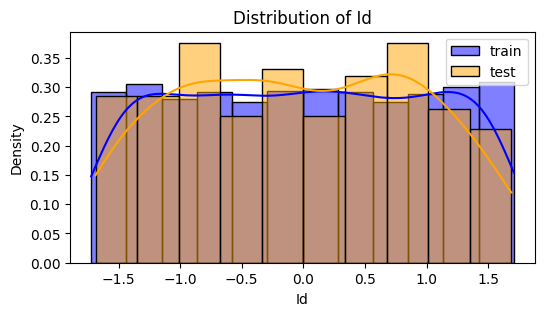

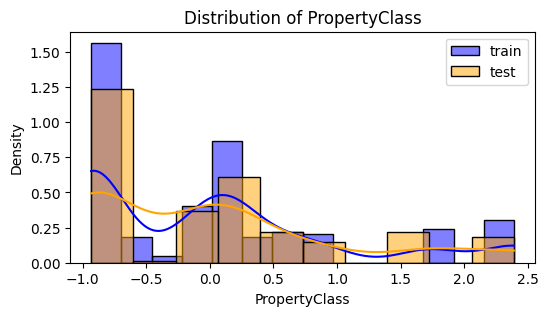

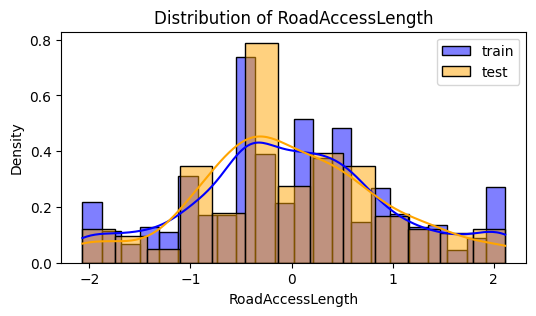

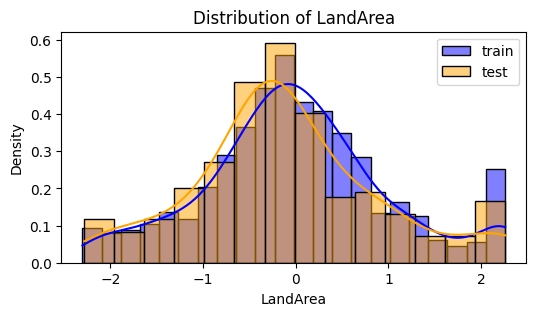

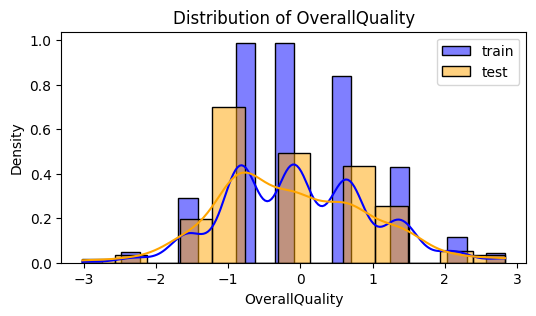

<Figure size 600x300 with 0 Axes>

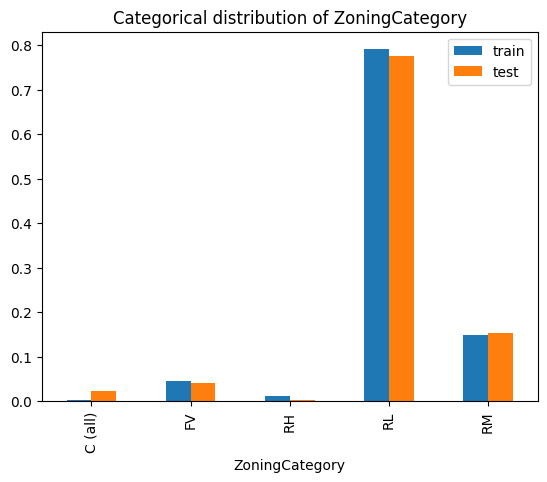

<Figure size 600x300 with 0 Axes>

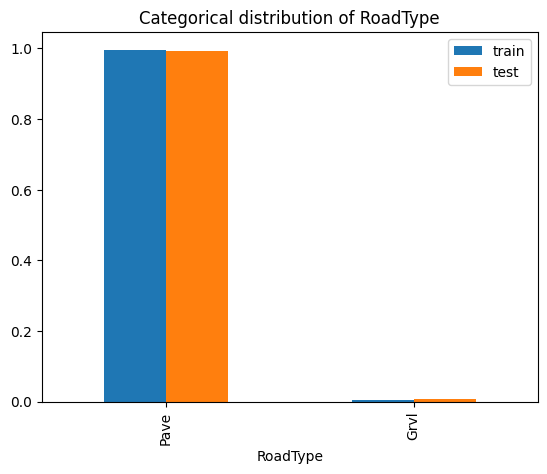

<Figure size 600x300 with 0 Axes>

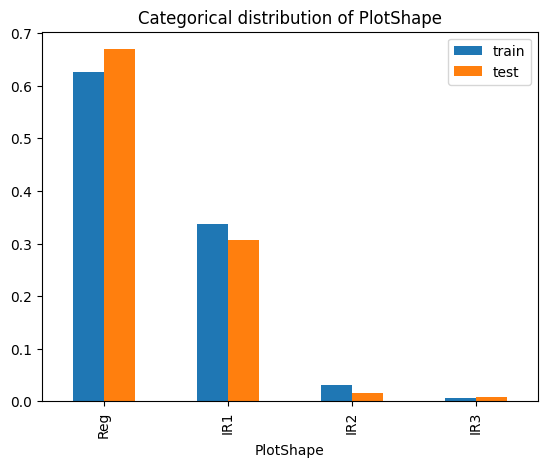

<Figure size 600x300 with 0 Axes>

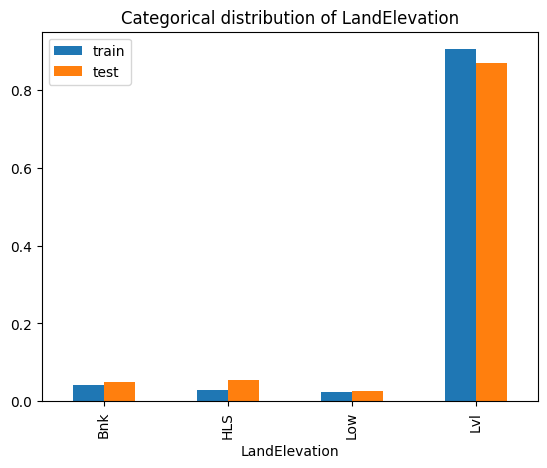

<Figure size 600x300 with 0 Axes>

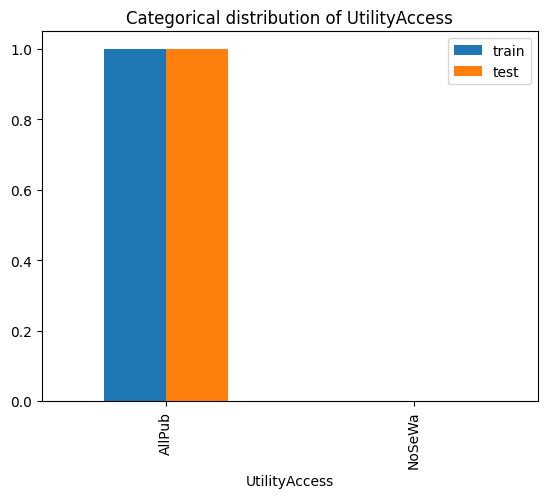

In [64]:

# =======================
#  Check columns
# =======================
train_cols = set(train.columns)
test_cols = set(test.columns)

print("Columns in train not in test:", train_cols - test_cols)
print("Columns in test not in train:", test_cols - train_cols)

# =======================
# Check categorical values
# =======================
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if col in test.columns:
        train_vals = set(train[col].unique())
        test_vals = set(test[col].unique())
        unseen = test_vals - train_vals
        if unseen:
            print(f"Column '{col}' has unseen test values:", unseen)

# =======================
# Check numeric scaling
# =======================
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
common_numeric_cols = [col for col in numeric_cols if col in test.columns]

print("\nNumeric column means (train vs test):")
for col in common_numeric_cols:
    print(f"{col}: train mean={train[col].mean():.3f}, test mean={test[col].mean():.3f}")

# =======================
#  Check missing values
# =======================
print("\nTotal missing values:")
print("Train:", train.isna().sum().sum())
print("Test:", test.isna().sum().sum())

# =======================
#  Plot numeric distributions (optional)
# =======================
for col in common_numeric_cols[:5]:  # check first 5 numeric features
    plt.figure(figsize=(6,3))
    sns.histplot(train[col], color='blue', label='train', kde=True, stat="density")
    sns.histplot(test[col], color='orange', label='test', kde=True, stat="density")
    plt.title(f"Distribution of {col}")
    plt.legend()
    plt.show()

# =======================
# Optional: check categorical distributions
# =======================
for col in categorical_cols[:5]:  # check first 5 categorical features
    if col in test.columns:
        plt.figure(figsize=(6,3))
        train_counts = train[col].value_counts(normalize=True)
        test_counts = test[col].value_counts(normalize=True)
        df_plot = pd.DataFrame({'train': train_counts, 'test': test_counts}).fillna(0)
        df_plot.plot(kind='bar')
        plt.title(f"Categorical distribution of {col}")
        plt.show()